In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
ct_images_path = 'D:\CANCER-DETECTION\CXR_png'
masks_path = 'D:\CANCER-DETECTION\masks'
img_size = (256, 256)  # Fixed size for resizing images

In [3]:
def load_images_and_masks(ct_images_path, masks_path):
    ct_images = []
    masks = []
    filenames = []
    img_size = (256, 256)
    c = 0
    for filename in os.listdir(ct_images_path):
        if filename.endswith('.png'):
            image_path = os.path.join(ct_images_path, filename)
            ct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            ct_image = cv2.resize(ct_image, img_size)
            ct_image = ct_image.astype(np.float32) / 255.0

            mask_filename = filename.replace('.png', '_mask.png')
            mask_path = os.path.join(masks_path, mask_filename)

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                #mask = mask.astype(np.float32) / 255.0
            else:
                c=c+1
                print(f"Mask not found for {filename}, using default mask.",c)

            ct_images.append(ct_image)
            masks.append(mask)
            filenames.append(filename)

    return np.array(ct_images), np.array(masks), filenames

ct_images, masks, filenames = load_images_and_masks(ct_images_path, masks_path)

Mask not found for CHNCXR_0025_0.png, using default mask. 1
Mask not found for CHNCXR_0036_0.png, using default mask. 2
Mask not found for CHNCXR_0037_0.png, using default mask. 3
Mask not found for CHNCXR_0038_0.png, using default mask. 4
Mask not found for CHNCXR_0039_0.png, using default mask. 5
Mask not found for CHNCXR_0040_0.png, using default mask. 6
Mask not found for CHNCXR_0065_0.png, using default mask. 7
Mask not found for CHNCXR_0181_0.png, using default mask. 8
Mask not found for CHNCXR_0182_0.png, using default mask. 9
Mask not found for CHNCXR_0183_0.png, using default mask. 10
Mask not found for CHNCXR_0184_0.png, using default mask. 11
Mask not found for CHNCXR_0185_0.png, using default mask. 12
Mask not found for CHNCXR_0186_0.png, using default mask. 13
Mask not found for CHNCXR_0187_0.png, using default mask. 14
Mask not found for CHNCXR_0188_0.png, using default mask. 15
Mask not found for CHNCXR_0189_0.png, using default mask. 16
Mask not found for CHNCXR_0190_0.

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


def load_images_and_masks(ct_images_path, masks_path, img_size):
    ct_images = []
    masks = []
    filenames = []
    c=0
    # Collect all mask filenames
    mask_filenames = set()
    for filename in os.listdir(masks_path):
        if filename.endswith('_mask.png'):
            mask_filenames.add(filename.replace('_mask.png', '.png'))

    # Load all CT scan images and corresponding masks
    for filename in os.listdir(ct_images_path):
        if filename.endswith('.png') and filename in mask_filenames:
            image_path = os.path.join(ct_images_path, filename)
            mask_filename = filename.replace('.png', '_mask.png')
            mask_path = os.path.join(masks_path, mask_filename)

            ct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if ct_image is not None and mask is not None:
                ct_image = cv2.resize(ct_image, img_size)
                ct_image = ct_image.astype(np.float32) / 255.0

                mask = cv2.resize(mask, img_size)
                mask = mask.astype(np.float32) / 255.0

                ct_images.append(ct_image)
                masks.append(mask)
                filenames.append(filename)
            else:
                c=c+1
                print(f"Error reading {filename} or {mask_filename}",c)

    return np.array(ct_images), np.array(masks), filenames

ct_images, masks, filenames = load_images_and_masks(ct_images_path, masks_path, img_size)

# Split data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(ct_images, masks, test_size=0.2, random_state=42)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(ct_images, masks, test_size=0.2, random_state=42)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

#metrics = [] 

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoding path
    up1 = UpSampling2D(size=(2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 256)     │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 384)     │               0 │ conv2d_3[0][0],            │
│                               │                           │                 │ up_sampling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 128)     │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 128)     │               0 │ conv2d_7[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ up_sampling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
X_train = X_train.reshape(-1, 256, 256, 1)
X_val = X_val.reshape(-1, 256, 256, 1)
y_train = y_train.reshape(-1, 256, 256, 1)
y_val = y_val.reshape(-1, 256, 256, 1)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=4)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.7455 - loss: 0.5017 - precision: 0.4766 - recall: 0.1436 - val_accuracy: 0.9295 - val_loss: 0.1985 - val_precision: 0.8974 - val_recall: 0.8097
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9261 - loss: 0.1937 - precision: 0.8910 - recall: 0.8137 - val_accuracy: 0.9452 - val_loss: 0.1447 - val_precision: 0.8851 - val_recall: 0.8979
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9456 - loss: 0.1396 - precision: 0.9055 - recall: 0.8765 - val_accuracy: 0.9521 - val_loss: 0.1291 - val_precision: 0.9020 - val_recall: 0.9084
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9495 - loss: 0.1333 - precision: 0.9128 - recall: 0.8871 - val_accuracy: 0.9545 - val_loss: 0.1243 - val_precision: 0.9517 - val_recall: 0.8619
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.9546 - loss: 0.1211 - precision: 0.9237 - recall: 0.8980 - val_accuracy: 0.9457 - val_loss: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


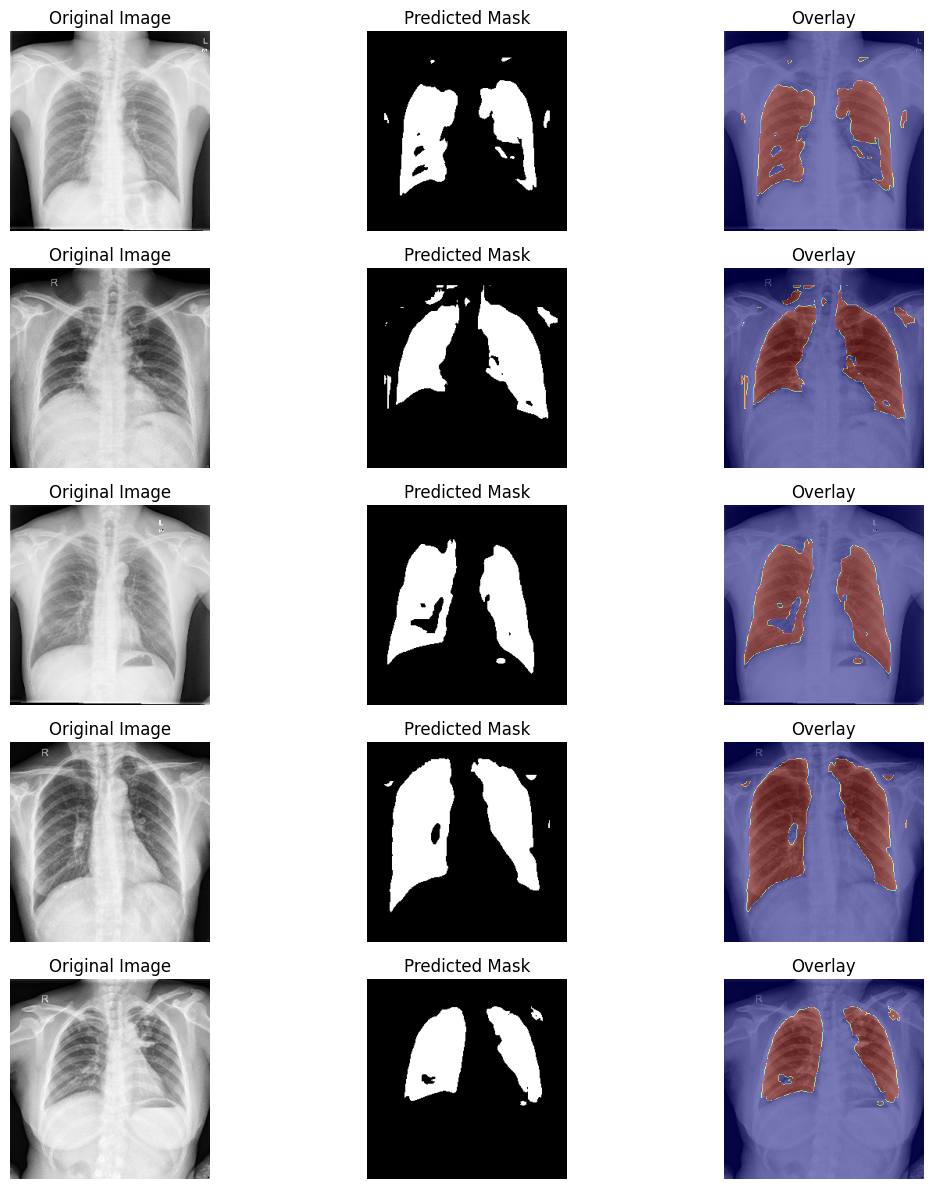

In [8]:
import matplotlib.pyplot as plt

def plot_sample_results(test_images, predictions, n=5):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(n, 3, i*3+1)
        plt.imshow(test_images[i].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(n, 3, i*3+2)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(n, 3, i*3+3)
        plt.imshow(test_images[i].reshape(256, 256), cmap='gray')
        plt.imshow(predictions[i].reshape(256, 256), cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get predictions on validation set
predictions = model.predict(X_val)

# Binarize predictions
predictions = (predictions > 0.5).astype(np.uint8)

# Visualize results
plot_sample_results(X_val, predictions)


In [9]:
import os
import csv

# Define the folder containing the patient files
folder_path = 'D:\CANCER-DETECTION\ClinicalReadings'  # Update this to your actual folder path

# Define the output CSV file path
output_csv = 'D:\CANCER-DETECTION\output.csv'  # Update this to your desired output CSV path

# Function to normalize gender
def normalize_gender(gender):
    if gender.lower() == 'f' or 'Female':
        return 'female'
    elif gender.lower() == 'm' or 'Male':
        return 'male'
    return gender

# Function to normalize age
def normalize_age(age):
    if age.lower().endswith('y'):
        return age[:-1] + 'yrs'
    return age

# Open the CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    # Define the CSV writer
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['File Name', 'Gender', 'Age', 'Disease'])
    
    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file (and not a directory)
        if os.path.isfile(file_path):
            # Open and read the content of the file
            with open(file_path, 'r') as file:
                lines = file.readlines()
                
                # Ensure there are at least 2 lines
                if len(lines) >= 2:
                    # Extract and clean the lines
                    personal_info_line = lines[0].strip()
                    disease_info = lines[1].strip()

                    # Handle the different possible formats
                    if personal_info_line.lower().startswith("patient's sex:"):
                        parts = personal_info_line.split()
                        gender = normalize_gender(parts[-1])
                        age = normalize_age(lines[1].strip().split()[-1])
                        disease_info = ' '.join(lines[2:]).strip() if len(lines) > 2 else ''  # Consider disease information on subsequent lines
                    else:
                        personal_info = personal_info_line.split()
                        if len(personal_info) >= 2:
                            gender = normalize_gender(personal_info[0])
                            age = normalize_age(personal_info[1])
                        else:
                            print(f"Skipping file {filename}: Unable to parse personal info.")
                            continue
                    
                    # Write the row to the CSV file
                    writer.writerow([filename, gender, age, disease_info])
                else:
                    print(f"Skipping file {filename}: Not enough lines.")
                    
print(f'Data has been written to {output_csv}')


Skipping file CHNCXR_0659_1.txt: Unable to parse personal info.
Data has been written to D:\CANCER-DETECTION\output.csv


In [10]:
len(filenames)

566

In [11]:
import pandas as pd
import os

# List of segmented image file names
segmented_image_files = filenames

# Path to the CSV file
csv_file_path = "D:\CANCER-DETECTION\output.csv"  # Update this to your actual CSV file path

# Extract base names (without extension) from segmented image files
segmented_image_basenames = [os.path.splitext(name)[0] for name in segmented_image_files]

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract base names (without extension) from the CSV file names
df['Base Name'] = df['File Name'].apply(lambda x: os.path.splitext(x)[0])

# Filter the DataFrame to keep only rows where 'Base Name' is in the list of segmented image base names
df_filtered = df[df['Base Name'].isin(segmented_image_basenames)]

# Drop the 'Base Name' column as it's no longer needed
df_filtered = df_filtered.drop(columns=['Base Name'])

# Save the filtered DataFrame back to the CSV file
df_filtered.to_csv(csv_file_path, index=False)

print(f'Filtered data has been written to {csv_file_path}')


Filtered data has been written to D:\CANCER-DETECTION\output.csv


In [12]:
csv_file_path = "D:\CANCER-DETECTION\output.csv"
df = pd.read_csv(csv_file_path)

df['Disease'] = df['Disease'].apply(lambda x: 'normal' if x.strip().lower() == 'normal' else 'abnormal')
df.to_csv(csv_file_path, index=False)

In [13]:
csv_file_path = 'D:\CANCER-DETECTION\output.csv'  # Update this to your actual CSV file path

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Correct the rows where "abnormal" is in the "Age" column
def correct_age_disease(row):
    if 'abnormal' in str(row['Age']).lower():
        row['Disease'] = 'abnormal'
        row['Age'] = ''  # Or set to NaN or an appropriate age value if known
    return row

df = df.apply(correct_age_disease, axis=1)

# Update the 'Disease' column: if it's not 'normal', change it to 'abnormal'
df['Disease'] = df['Disease'].apply(lambda x: 'normal' if str(x).strip().lower() == 'normal' else 'abnormal')

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

In [14]:
df['Disease'].value_counts()

Disease
abnormal    286
normal      279
Name: count, dtype: int64

In [26]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Paths to the directories and CSV file
segmented_masks_path = "D:\\CANCER-DETECTION\\masks"
csv_file_path = "D:\\CANCER-DETECTION\\output.csv"

# Load the CSV file
patient_data = pd.read_csv(csv_file_path)

In [27]:
# Function to load segmented mask images
def load_segmented_masks(segmented_masks_path, target_size=(256, 256)):
    masks = []
    filenames = []

    mask_files = [f for f in os.listdir(segmented_masks_path) if f.endswith('_mask.png')]

    for mask_file in mask_files:
        mask_path = os.path.join(segmented_masks_path, mask_file)
        mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
        mask = img_to_array(mask)
        
        # Normalize
        mask = mask / 255.0
        
        masks.append(mask)
        filenames.append(mask_file.replace('_mask.png', '.txt'))

    return np.array(masks), filenames

masks, mask_filenames = load_segmented_masks(segmented_masks_path)

In [30]:
# Create a DataFrame for the mask filenames
mask_df = pd.DataFrame(mask_filenames, columns=['File Name'])

# Ensure the 'filename' column in patient_data matches the format of mask_filenames
patient_data['File Name'] = patient_data['File Name'].apply(lambda x: x.replace('.png', ''))

# Debugging: Find mask filenames without corresponding entries in the CSV
mask_filenames_set = set(mask_filenames)
csv_filenames_set = set(patient_data['File Name'])

missing_in_csv = mask_filenames_set - csv_filenames_set
missing_in_masks = csv_filenames_set - mask_filenames_set

print(f"Number of mask files missing in CSV: {len(missing_in_csv)}")
print(f"Number of CSV entries missing in masks: {len(missing_in_masks)}")

if len(missing_in_csv) > 0:
    print("Mask files missing in CSV:")
    print(missing_in_csv)

if len(missing_in_masks) > 0:
    print("CSV entries missing in masks:")
    print(missing_in_masks)

Number of mask files missing in CSV: 0
Number of CSV entries missing in masks: 0


In [31]:
# Remove inconsistencies
mask_df = mask_df[mask_df['File Name'].isin(csv_filenames_set)]
patient_data = patient_data[patient_data['File Name'].isin(mask_filenames_set)]

In [32]:
# Merge the mask DataFrame with the patient data CSV on the file name
merged_data = pd.merge(mask_df, patient_data, on='File Name', how='inner')

In [33]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = merged_data['Disease']
labels_encoded = label_encoder.fit_transform(labels)

# Check consistency between masks and labels
assert len(masks) == len(labels_encoded), "Mismatch in the number of masks and labels"

In [34]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(masks, labels_encoded, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(label_encoder.classes_))

In [43]:
# Define a simple CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (256, 256, 1)  # Adjust this according to your input size
num_classes = len(label_encoder.classes_)
model = build_cnn(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [46]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.8982 - loss: 0.3304 - precision_4: 0.8982 - recall_4: 0.8982 - val_accuracy: 0.6903 - val_loss: 0.6937 - val_precision_4: 0.6903 - val_recall_4: 0.6903
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.8985 - loss: 0.2327 - precision_4: 0.8985 - recall_4: 0.8985 - val_accuracy: 0.7168 - val_loss: 0.7659 - val_precision_4: 0.7168 - val_recall_4: 0.7168
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.9361 - loss: 0.2128 - precision_4: 0.9361 - recall_4: 0.9361 - val_accuracy: 0.7257 - val_loss: 1.0363 - val_precision_4: 0.7257 - val_recall_4: 0.7257
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - accuracy: 0.9525 - loss: 0.1286 - precision_4: 0.9525 - recall_4: 0.9525 - val_accuracy: 0.7257 - val_loss: 1.1487 - val_precision_4: 0.7257 - val_recall_4: 0.7257
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.9473 - loss: 0.1565 - precision_4: 0.9473 - recall_4: 0.9473 -